# Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.manifold import TSNE
from torchvision.utils import make_grid, save_image
from PIL import Image

# Load MNIST dataset
from data import train_loader, test_loader

# Build Conditional Variational AutoEncoder

In [2]:
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, img_size=28, labels=10):
        super().__init__()

        # Build encoder
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(32, 16)  # mean of latent space
        self.fc_var = nn.Linear(32, 16) # **log variance** of latent space

        # Build decoder
        self.decoder = nn.Sequential(
            nn.Linear(16 + labels, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, img_size * img_size),
            nn.Tanh(),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label):
        label = F.one_hot(label, 10)
        z = torch.cat([z, label], dim=1)
        return self.decoder(z)
    
    def forward(self, x, label):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, label), mu, log_var

# Train

Let's use Adam optimizer and beautiful loss function. 

In [3]:
# Deriving the KLD Loss: https://arxiv.org/pdf/1907.08956v1.pdf
reconstruction_function = nn.MSELoss(size_average=False)
def loss_func(x, x_hat, mu, log_var):
    reconstruction_loss = reconstruction_function(x_hat, x)
    kld_loss = torch.sum(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return reconstruction_loss + kld_loss, reconstruction_loss, kld_loss

/home/baek/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [4]:
# Check whether gpu is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device: {}".format(device))

Using device: cuda


In [5]:
model = ConditionalVariationalAutoEncoder(img_size=28, labels=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    for data in train_loader:
        img, label = data
        img = img.view(img.size(0), -1).to(device)
        # ===================forward=====================
        output, mu, log_var = model(img, label.to(device))
        loss, reconstruction_loss, kld_loss = loss_func(output, img, mu, log_var)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print("epoch [{}/{}], loss:{:.4f}, recons_loss:{:.4f}, kld_loss:{:.4f}".format(epoch + 1, 10, loss.item(), reconstruction_loss.item(), kld_loss.item()))

epoch [1/10], loss:3630.2209, recons_loss:3325.8604, kld_loss:304.3606
epoch [2/10], loss:3621.3506, recons_loss:3318.5198, kld_loss:302.8309
epoch [3/10], loss:3348.3474, recons_loss:2988.8350, kld_loss:359.5124
epoch [4/10], loss:3186.1987, recons_loss:2802.5718, kld_loss:383.6270
epoch [5/10], loss:3159.0859, recons_loss:2776.1787, kld_loss:382.9073
epoch [6/10], loss:2913.7822, recons_loss:2519.7505, kld_loss:394.0318
epoch [7/10], loss:3138.2620, recons_loss:2734.4297, kld_loss:403.8322
epoch [8/10], loss:2958.3599, recons_loss:2560.2729, kld_loss:398.0869
epoch [9/10], loss:2907.8167, recons_loss:2514.9050, kld_loss:392.9117
epoch [10/10], loss:3135.2888, recons_loss:2721.0369, kld_loss:414.2520
epoch [11/10], loss:2534.9814, recons_loss:2130.9028, kld_loss:404.0785
epoch [12/10], loss:2596.1926, recons_loss:2194.5557, kld_loss:401.6370
epoch [13/10], loss:2787.2188, recons_loss:2384.1421, kld_loss:403.0766
epoch [14/10], loss:2857.4114, recons_loss:2441.8721, kld_loss:415.5392
e

# Eval - Check the loss

In [6]:
_ = model.eval()
model = model.to("cpu")

recons_loss = []
kld_loss = []
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        output, mu, log_var = model(img, label)
        _, recons_l, kld_l = loss_func(output, img, mu, log_var)
        recons_loss.append(recons_l.item())
        kld_loss.append(kld_l.item())

print("test recons_loss:{:.4f}, kld_loss:{:.4f}".format(np.array(recons_loss).mean(), np.array(kld_loss).mean()))

test recons_loss:4343.6023, kld_loss:824.8018


# Eval - Feature Representation

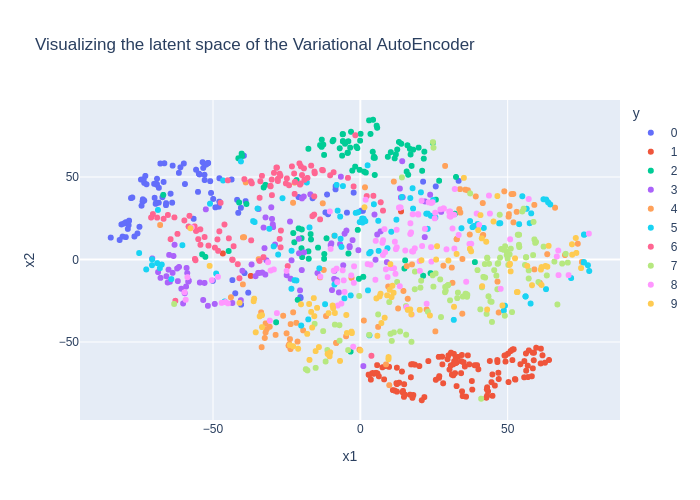

In [7]:
X = []
y = []

with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        X.append(model.encoder(img.view(img.size(0), -1)).numpy())
        y.append(y_real.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

df = pd.DataFrame(data=np.concatenate([X_embedded, y.reshape(-1, 1)], axis=-1), columns=["x1", "x2", "y"])
df["y"] = df["y"].astype(int).astype("category")

fig = px.scatter(df.sample(n=1000).sort_values("y"), x="x1", y="x2", color="y", title="Visualizing the latent space of the Variational AutoEncoder")

fig.write_image("images/cvae-fig1.png")
Image.open("images/cvae-fig1.png")

# Eval - Reconstruction

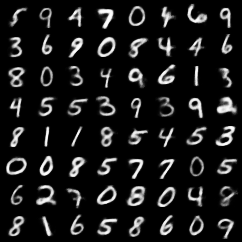

In [8]:
with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        output, _, _ = model(img.view(img.size(0), -1), y_real)
        break

img_grid = make_grid(output.reshape(-1, 1, 28, 28), nrow=8, normalize=True)
save_image(img_grid, "images/cvae-fig2.png")
Image.open("images/cvae-fig2.png")

# Eval - Generation

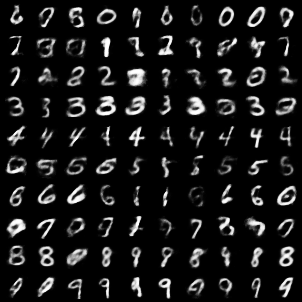

In [9]:
z = torch.randn_like(torch.empty(100, 16))
labels = torch.LongTensor([[i] * 10 for i in range(10)]).view(-1)
output = model.decode(z, labels)
img_grid = make_grid(output.reshape(-1, 1, 28, 28), nrow=10, normalize=True)
save_image(img_grid, "images/cvae-fig3.png")
Image.open("images/cvae-fig3.png")